# Inference example for trained 2D U-Net model on BraTS.
Takes a trained model and performs inference on a few validation examples.

In [1]:
import sys
print (sys.executable)
# !export MKLDNN_VERBOSE=2

/home/sksobhee/miniconda3/envs/idp/bin/python


In [2]:
%matplotlib inline
import os
import psutil
import numpy as np
import keras as K
import h5py
import time
import tensorflow as tf 
import sys; sys.argv=['']; del sys

from distutils.sysconfig import get_python_lib
packages_directory=get_python_lib()

from argparser import args

if args.keras_api:
    import keras as K
else:
    from tensorflow import keras as K

import matplotlib.pyplot as plt

onnx=False
#TODO - Enable nGraph Bridge - Switch to (decathlon) venv!

if onnx:
    #TODO - Include ngraph onnx backend
    import onnx
    from ngraph_onnx.onnx_importer.importer import import_onnx_model
    import ngraph as ng

# print ("We are using Tensorflow version", tf.__version__,\
#        "with Intel(R) MKL", "enabled" if tf.pywrap_tensorflow.IsMklEnabled() else "disabled",)

os.environ['MKLDNN_VERBOSE'] = "2"

Using TensorFlow backend.


In [3]:
#TODO: Set the multi-threading parameters for Tensorflow. 
config = tf.ConfigProto(intra_op_parallelism_threads=args.num_threads,
                        inter_op_parallelism_threads=args.num_inter_threads)

sess = tf.Session(config=config)

K.backend.set_session(sess)

In [4]:
# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)
    
data_fn = os.path.join(args.data_path, args.data_filename)
model_fn = os.path.join(args.output_path, args.inference_filename)

In [5]:
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata= tf.RunMetadata()

#### Define the DICE coefficient and loss function

The Sørensen–Dice coefficient is a statistic used for comparing the similarity of two samples. Given two sets, X and Y, it is defined as

\begin{equation}
dice = \frac{2|X\cap Y|}{|X|+|Y|}
\end{equation}

In [6]:
def sensitivity(y_true, y_pred, axis=(1,2,3), smooth=1.):
    return 1
    
def specificity(y_true, y_pred, axis=(1,2,3), smooth=1.):
    return 1

def calc_dice(y_true, y_pred, smooth=1.):
    """
    Sorensen Dice coefficient
    """
    numerator = 2.0 * np.sum(y_true * y_pred) + smooth
    denominator = np.sum(y_true) + np.sum(y_pred) + smooth
    coef = numerator / denominator

    return coef

def dice_coef(y_true, y_pred, axis=(1, 2), smooth=1.):
    """
    Sorenson (Soft) Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true + y_pred, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def dice_coef_loss(target, prediction, axis=(1, 2), smooth=1.):
    """
    Sorenson (Soft) Dice loss
    Using -log(Dice) as the loss since it is better behaved.
    Also, the log allows avoidance of the division which
    can help prevent underflow when the numbers are very small.
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.log(2.*numerator) + tf.log(denominator)

    return dice_loss


def combined_dice_ce_loss(y_true, y_pred, axis=(1, 2), smooth=1., weight=0.9):
    """
    Combined Dice and Binary Cross Entropy Loss
    """
    return weight*dice_coef_loss(y_true, y_pred, axis, smooth) + \
        (1-weight)*K.losses.binary_crossentropy(y_true, y_pred)

## Inference Time!

Inferencing in this example can be done in 3 simple steps:
1. Load the data
1. Load the Keras model 
1. Perform a `model.predict` on an input image (or set of images)

#### Step 1 : Load data

In [7]:
df = h5py.File(data_fn, "r")
imgs_validation = df["imgs_validation"]
msks_validation = df["msks_validation"]

#### Step 2 : Load the model

In [8]:
model = K.models.load_model(model_fn, custom_objects={
"sensitivity": sensitivity,
"specificity": specificity,
"combined_dice_ce_loss": combined_dice_ce_loss,
"dice_coef_loss": dice_coef_loss,
"dice_coef": dice_coef})

#### Step 3 (final step): Perform prediction with `model.predict`

We first define a convenience function that performs a prediction on one image. This function takes an image ID and a flag `plot_result` which we can use to toggle displaying the results graphically. 

After we have performed a prediction, we calculate the dice score to analyze how good out prediction was compared to the ground truth. 

In [9]:
def predict(img_no, plot_result):
    """
    Calculate the Dice and plot the predicted masks for image # img_no
    """

    img = imgs_validation[[img_no], ]
    msk = msks_validation[[img_no], ]
    
    #TODO load onnx model in ngraph
    if onnx:
        onnx_protobuf = onnx.load('./output/unet_model_for_decathlon_100_iter.onnx')
        ng_models = import_onnx_model(onnx_protobuf)
        ng_model = ng_models[0]
        runtime = ng.runtime(backend_name='CPU')
        unet = runtime.computation(ng_model['output'], *ng_model['inputs'])
        
        start_time = time.time()
        pred_mask= unet(img)[0]
        print ("Time for prediction ngraph: ", '%.0f'%((time.time()-start_time)*1000),"ms")

    else:
        start_time = time.time()
        pred_mask = model.predict(img, verbose=0, steps=None)
        print ("Time for prediction TF: ", '%.0f'%((time.time()-start_time)*1000),"ms")
        
    dice_score = calc_dice(pred_mask, msk)

    print("Dice score for Image #{} = {:.4f}".format(img_no,
                                                     dice_score))
    if plot_result:
        plt.figure(figsize=(15, 15))
        plt.subplot(1, 3, 1)
        plt.imshow(img[0, :, :, 0], cmap="bone", origin="lower")
        plt.axis("off")
        plt.title("MRI Input", fontsize=20)
        plt.subplot(1, 3, 2)
        plt.imshow(msk[0, :, :, 0], origin="lower")
        plt.axis("off")
        plt.title("Ground truth", fontsize=20)
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[0, :, :, 0], origin="lower")
        plt.axis("off")
        plt.title("Prediction\nDice = {:.4f}".format(dice_score), fontsize=20)

        plt.tight_layout()

        png_name = os.path.join(png_directory, "pred{}.png".format(img_no))
        plt.savefig(png_name, bbox_inches="tight", pad_inches=0)
        print("Saved png file to {}".format(png_name))

#### Step 3 (continued) : Perform prediction on some images. 
Use `plot_result=True/False` to toggle plotting the results. If `plot_result=True`, the prediction results will be saved in the output directory for images, which is defined by the `png_directory` variable.

Time for prediction TF:  341 ms
Dice score for Image #54 = 0.7804
Saved png file to inference_examples/pred54.png


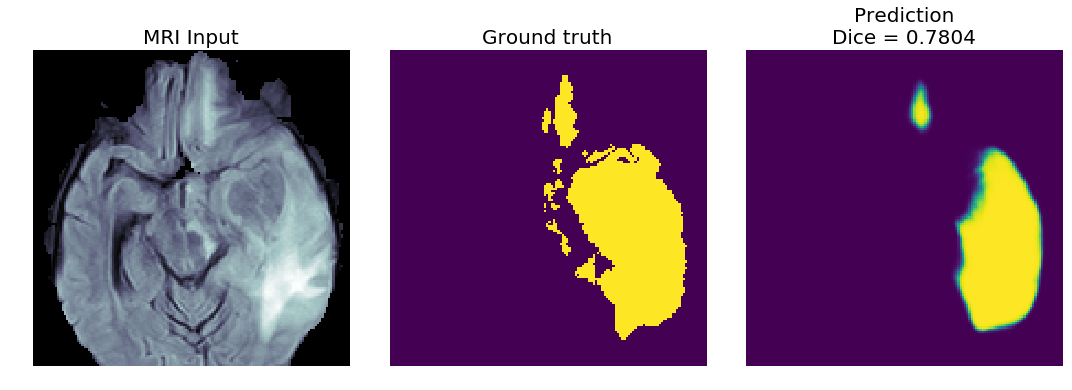

In [10]:
indicies_validation = [54] #[40]

for idx in indicies_validation:
    predict(idx, plot_result=True)

In [11]:
# %save myscript.py 1-9

## OpenVINO

In order to use OpenVINO, we need to do a few steps:

1. Convert our Keras model to a Tensorflow model. 
1. Freeze the Tensorflow saved format model
1. Use the OpenVINO Model Optimizer to convert the above freezed-model to the OpenVINO Intermediate Representation (IR) format
1. Validation
1. Inference time :)

#### Step1 : Convert our Keras model to a Tensorflow model

In [12]:
"""
If there are other custom loss and metric functions you'll need to specify them
and add them to the dictionary below.
"""
# model = keras.models.load_model(args.input_filename, custom_objects={
#                                 "dice_coef": dice_coef,
#                                 "sensitivity": sensitivity,
#                                 "specificity": specificity,
#                                 "combined_dice_ce_loss": combined_dice_ce_loss,
#                                 "dice_coef_loss": dice_coef_loss})

"\nIf there are other custom loss and metric functions you'll need to specify them\nand add them to the dictionary below.\n"

In [13]:
signature = tf.saved_model.signature_def_utils.predict_signature_def(
    inputs={'input': model.input}, outputs={'output': model.output})

print("Saving the model to directory {}".format(args.output_directory))

builder = tf.saved_model.builder.SavedModelBuilder(args.output_directory)
builder.add_meta_graph_and_variables(sess=sess,    
                                     tags=[tf.saved_model.tag_constants.SERVING],    
                                     signature_def_map={
                                         tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:signature
                                     })
builder.save()
print("TensorFlow protobuf version of model is saved.")

print("Model input name = ", model.input.op.name)
print("Model input shape = ", model.input.shape)
print("Model output name = ", model.output.op.name)
print("Model output shape = ", model.output.shape)

Saving the model to directory saved_2dunet_model_protobuf
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: saved_2dunet_model_protobuf/saved_model.pb
TensorFlow protobuf version of model is saved.
Model input name =  MRImages
Model input shape =  (?, 144, 144, 4)
Model output name =  PredictionMask/Sigmoid
Model output shape =  (?, 144, 144, 1)


`Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0`

#### Step 2: Freeze the Tensorflow saved format model

To freeze the mode, we create a folder `frozel_model` and use Tensorflow's `freeze_graph.py`. 
Why we do this: https://blog.metaflow.fr/tensorflow-how-to-freeze-a-model-and-serve-it-with-a-python-api-d4f3596b3adc


In [30]:
!mkdir output/frozen_model

mkdir: cannot create directory ‘output/frozen_model’: File exists


In [16]:
print(packages_directory)
print(args.output_directory)
print(model.output.op.name)
od = 'output/saved_2dunet_model_protobuf'

/home/sksobhee/miniconda3/envs/idp/lib/python3.6/site-packages
saved_2dunet_model_protobuf
PredictionMask/Sigmoid


In [29]:
path = packages_directory + '/tensorflow/python/tools/freeze_graph.py'
%alias path1 path
print (path)
# %run -i /home/sksobhee/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/tools/freeze_graph.py

/home/sksobhee/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/tools/freeze_graph.py
Input checkpoint '' doesn't exist!


In [33]:
print()
print()
print("="*30)
print("To freeze this model, run the commands:")
print("mkdir frozen_model")
print("python {}/tensorflow/python/tools/freeze_graph.py "
       "--input_saved_model_dir {} "
       "--output_node_names {} "
       "--output_graph frozen_model/saved_model_frozen.pb".format(packages_directory,
       args.output_directory, model.output.op.name))



To freeze this model, run the commands:
mkdir frozen_model
python /home/sksobhee/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/tools/freeze_graph.py --input_saved_model_dir saved_2dunet_model_protobuf --output_node_names PredictionMask/Sigmoid --output_graph frozen_model/saved_model_frozen.pb


In [31]:
from tensorflow.python.tools.freeze_graph import freeze_graph 

In [32]:
freeze_graph(input_graph', 'input_saver', 'input_binary', 'input_checkpoint', 'restore_op_name', 'filename_tensor_name', 'clear_devices', and 'initializer_nodes
            input_saved_model_dir=args.output_directory,
             output_node_names=model.output.op.name,
             output_graph='frozen_model/saved_model_frozen.pb')


TypeError: freeze_graph() missing 8 required positional arguments: 'input_graph', 'input_saver', 'input_binary', 'input_checkpoint', 'restore_op_name', 'filename_tensor_name', 'clear_devices', and 'initializer_nodes'